# Goals

* Use map-reduce-subgraph framework with SRA tools agent
* [X] Handle GEO record conversion to SRA
* [ ] Make sure that the datasets are thoroughly researched
* [ ] Handle conversion to SRP accessions

In [23]:
# import 
import os
import re
import time
from enum import Enum
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [24]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [25]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


# Tools

In [26]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

In [27]:
@tool 
def esearch_all(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    """
    # debug model
    if os.getenv("DEBUG_MODE") == "TRUE":
        max_records = 2 

    # query
    records = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            # delete unneeded keys
            to_rm = ["Count", "RetMax", "RetStart"]
            for key in to_rm:
                if key in search_results.keys():
                    del search_results[key]
            # add to records
            records.append(search_results)
            # update retstart
            retstart += retmax
            time.sleep(0.5)
            if max_records and len(records) >= max_records:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
        
    # return records
    if len(records) == 0:
        return(f"No records found for query: {esearch_query}")
    if os.getenv("DEBUG_MODE") == "TRUE":
        records = records[:max_records]  # debug
    return records

# esearch.invoke({"esearch_query" : "ERX13336121", "database" : "sra"})

In [28]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    """
    # add date range
    start_date = datetime.now() - timedelta(days=7)
    end_date = datetime.now()
    date_range = f"{start_date.strftime('%Y/%m/%d')}:{end_date.strftime('%Y/%m/%d')}[PDAT]"
    esearch_query += f" AND {date_range}"

    # add mouse and human organism
    esearch_query += " AND (Homo sapiens[Organism] OR Mus musculus[Organism])"

    # debug model
    if os.getenv("DEBUG_MODE") == "TRUE":
        max_ids = 2 

    # query
    ids = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            ids.extend(search_results["IdList"])
            retstart += retmax
            time.sleep(0.5)
            if max_ids and len(ids) >= max_ids:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
        
    # return IDs
    if os.getenv("DEBUG_MODE") == "TRUE":
        ids = ids[:max_ids]  # debug
    return ids

# query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
# IDs = esearch_scrna.invoke({"esearch_query" : query, "database" : "sra"})
# IDs

In [29]:
@tool
def esummary(
    database: Annotated[str, "Database name ('sra' or 'gds')"],
    entrez_id: Annotated[str, "Entrez ID"],
) -> Annotated[List[str], "eSummary results in xml format"]:
    """
    Run an Entrez esummary query on an Entrez ID to obtain summary information for the record.
    """
    time.sleep(0.5)  # Respect NCBI's rate limits
    
    # all possible databases of interest
    databases = [
        "sra", "gds", "pubmed", "biosample", "bioproject", 
    ]
    

    # Fetch summary record
    try:
        handle = Entrez.esummary(db=database, id=entrez_id, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to fetch summary for {entrez_id}")
        return f"Failed to fetch summary for {entrez_id}. Check if the ID exists."
    finally:
        handle.close()
        
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass
        
    # check for errors in the response
    if "ERROR" in record.upper() or "INVALID_ID" in record.upper():
        return f"Failed to fetch summary for {entrez_id}. Try a different database (gds or sra) or verify the ID."
        
    return str(record)

# esummary.invoke({"database" : "sra", "entrez_id" : "35966237"})

In [30]:
@tool
def elink(
    source_db: Annotated[str, "Source database (e.g., 'sra')"],
    target_db: Annotated[str, "Target database (e.g., 'bioproject', 'biosample', 'pubmed')"],
    entrez_id: Annotated[str, "Entrez ID "],
) -> Annotated[str, "eLink results in xml format"]:
    """
    Find related entries between Entrez databases, particularly useful for finding
    BioProject, BioSample, or publication records related to SRA entries.
    """
    time.sleep(0.5)  # Respect NCBI's rate limits
    
    try:
        handle = Entrez.elink(
            dbfrom=source_db,
            db=target_db,
            id=[entrez_id],
            retmode="xml"
        )
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to find links for: {entrez_id}")
        return f"Failed to find links. Check database names and Entrez ID."
    finally:
        handle.close()
        
    try:
        record = record.decode("utf-8")
    except:
        pass
        
    if "ERROR" in record.upper():
        return f"Failed to find links. Verify database names ({source_db}, {target_db}) and Entrez ID."
        
    return str(record)

# elink.invoke({"source_db" : "sra", "target_db" : "gds", "entrez_id" : "35966237"})

In [31]:
@tool 
def efetch(
    database: Annotated[str, "Database name ('sra' or 'gds')"],
    entrez_id: Annotated[str, "Entrez ID"],
    )-> Annotated[List[str], "eFetch results in xml format"]:
    """
    Run an Entrez efetch query on an Entrez ID to obtain metadata for the record.
    """
    time.sleep(0.5)
    # Fetch dataset record
    try:
        handle = Entrez.efetch(db=database, id=entrez_id, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to fetch record for {entrez_id}")
    finally:
        handle.close()
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass

    # check for errors
    if "Error occurred: cannot get document summary" in record:
        return f"Failed to fetch record for {entrez_id}. Try a different database (gds or sra)."

    return str(record)

#record = efetch.invoke({"database" : "sra", "entrez_id" : "35966237"})
#pprint(record)
#record = efetch.invoke({"database" : "gds", "entrez_id" : "200254051"})
#pprint(record)

In [32]:
@tool 
def get_pubmed_article(
    entrez_id: Annotated[str, "Entrez record ID"],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    )-> Annotated[str, "PubMed article metadata in xml format"]:
    """
    Get a PubMed article using Entrez efetch.
    """
    handle = Entrez.elink(dbfrom=database, db="pubmed", id=entrez_id)
    records = Entrez.read(handle)
    handle.close()
 
    # Fetch details for each paper
    papers = []
    for record in records:
        for pmid in record['IdList']:
            time.sleep(0.5)
            
            handle = Entrez.efetch(db="pubmed", id=pmid, rettype="abstract", retmode="text")
            paper_info = handle.read()
            handle.close()
        
            papers.append(paper_info)
    return "\n".join(papers)

# get_pubmed_article.invoke({"entrez_id" : "35966237"})


In [33]:
from subprocess import Popen, PIPE

def run_cmd(cmd: str) -> tuple:
    """
    Run sub-command and return returncode, output, and error.
    Args:
        cmd: Command to run
    Returns:
        tuple: (returncode, output, error)
    """
    p = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()
    return p.returncode, output, err

In [34]:
def entrez2sra(entrez_id: str) -> str:
    """
    Convert an Entrez ID to an SRA ID.
    Args:
        entrez_id: Entrez ID
    Returns:
        str: SRA ID
    """
    # Fetch SRA accession from record ID
    try:
        # Fetch the record from Entrez
        handle = Entrez.efetch(db="sra", id=entrez_id, retmode="xml")
        record = handle.read()
        handle.close()
        
        # Parse XML to get SRA accession
        root = ET.fromstring(record)
        # Look for SRA accession in the XML structure
        accession = root.find(".//EXPERIMENT").get("accession")
        # Check if we found an accession
        if not accession:
            return None,f"Could not find SRA accession for record ID {entrez_id}"  
    except Exception as e:
        return None,f"Failed to fetch SRA accession: {str(e)}"

    return accession,""

#entrez2sra("35966237")

In [35]:
@tool
def run_sra_stat(
    entrez_id: Annotated[str, "Entrez record ID"],
    tries: Annotated[int, "Number of attempts"]=3
    ) -> str: 
    """
    Run the sra-stat CLI command (SRA Tools) on an SRA accession.
    Use this tool to get information about the sequence data associated with the SRA accession.
    """
    # get SRA accession
    accession,err = entrez2sra(entrez_id)
    if not accession:
        return err

    # run sra-stat
    cmd = f'sra-stat --xml --quick {accession}'
    err = ""
    for i in range(tries):
        rc,output,err = run_cmd(cmd)
        if rc == 0:
            return output.decode("utf-8")
        # sleep prior to next attempt
        sleep_time = 5 * (i + 1)
        time.sleep(sleep_time)
    return f"Failed to run sra-stat: {err}"

# run_sra_stat.invoke({"entrez_id" : "35966237"})

In [36]:
@tool 
def geo2sra(
    entrez_ids: Annotated[List[str], "List of Entrez IDs for the GEO database"],
    )-> Annotated[List[str], "List linked Entrez IDs for SRA records"]:
    """
    Convert a GEO Entrez ID to SRA Entrez IDs.
    """
    sra_ids = []
    for entrez_id in entrez_ids:
        # Fetch detailed GEO record to get links to SRA
        handle = Entrez.elink(dbfrom="gds", db="sra", id=entrez_id)
        links = Entrez.read(handle)
        handle.close()
        
        if links[0]['LinkSetDb']:
            sra_ids += [link['Id'] for link in links[0]['LinkSetDb'][0]['Link']]
        time.sleep(0.34) 

    # debug mode
    if os.getenv("DEBUG_MODE") == "TRUE":
        sra_ids = sra_ids[:2]

    # return SRA IDs
    return sra_ids

#geo2sra.invoke({"entrez_ids" : ["200254051"]})
#geo2sra.invoke({"entrez_ids" : ["200268899"]})

# Graph

In [37]:
import operator
from typing import Annotated, Sequence, Tuple, Union, Required
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [38]:
# set model
model = ChatOpenAI(model="gpt-4o-mini")

## Subgraph

In [39]:
class YesNo(Enum):
    Yes = "Yes"
    No = "No"
    Not_sure = "Not sure"

class SubState(TypedDict):
    """
    Shared state of the agents in the subgraph
    """
    entrez_id: str
    database: str
    messages: Annotated[Sequence[BaseMessage], operator.add]
    accessions: Annotated[List[str], "SRA accessions associated with the dataset"]
    is_single_cell: Annotated[YesNo, "Whether the dataset is a single-cell RNA-seq dataset"]
    is_illumina: Annotated[YesNo, "Whether the dataset was generated using Illumina sequencing technology"]
    is_paired_end: Annotated[YesNo, "Whether the dataset is paired-end reads"]
    is_10x: Annotated[YesNo, "Whether the dataset was generated using 10x Genomics technology"]
    explanation: Annotated[str, "Concise determination on whether the dataset is actually a single-cell RNA-seq dataset"]

In [40]:
# create efetch tool node
def invoke_efetch(state: SubState):
    """
    Invoke the efetch tool to get metadata for an Entrez record.
    """
    # invoke tool
    record = efetch.invoke({"database" : state["database"], "entrez_id" : state["entrez_id"]})
    record = f"#-- efetch results --#\n{record}\n#-- end efetch results --#"
    # update messages
    return {"messages" : [HumanMessage(content=record)]}

# create sra-stat tool node
def invoke_get_pubmed_article(state: SubState):
    """
    Invoke the get_pubmed_article tool to get metadata for a PubMed article.
    """
    # invoke tool
    article = get_pubmed_article.invoke({"entrez_id" : state["entrez_id"]})
    article = f"#-- PubMed article information --#\n{article}\n#-- end PubMed article inforamtion --#"
    # update messages
    return {"messages" : [HumanMessage(content=article)]}

# create sra-stat tool node
def invoke_run_sra_stat(state: SubState):
    """
    Invoke the run_sra_stat tool to get metadata for an SRA record.
    """
    # invoke tool
    sra_stat = run_sra_stat.invoke({"entrez_id" : state["entrez_id"]})
    sra_stat = f"#-- sra-stat results --#\n{sra_stat}\n#-- end sra-stat results --#"
    # update messages
    return {"messages" : [HumanMessage(content=sra_stat)]}

In [41]:
# create summarization node
class ResearchSummary(TypedDict):
    """
    Summarize the research results.
    """
    accessions: List[str]
    is_single_cell: YesNo
    is_illumina: YesNo
    is_paired_end: YesNo
    is_10x: YesNo
    explanation: str 

def summarize_research(state: SubState) -> ResearchSummary:
    """
    Summarize the research results by incorporating previous conversation history.
    """
    # Create a prompt template that includes previous messages
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You will be provided with information on a dataset that may be a single-cell RNA-seq dataset."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "\n".join([
            "Based on the information above, determine the following:",
            "1. What SRA accessions are associated with the dataset?",
            " - Possible accessions are \"SRR\", \"SRX\", \"SRS\", \"SAMN\", \"SRP\", and \"SRA\".",
            "2. Is the dataset a single-cell RNA-seq?",
            " - Look for LIBRARY_SOURCE containing \"SINGLE CELL\" or similar terms.",
            " - Check LIBRARY_STRATEGY for \"RNA-Seq\"."
            " - Look for mentions of \"single-cell RNA-seq\" or \"scRNA-seq\" in the dataset description.",
            "3. Is the dataset Illumina sequencing?",
            " - Look for PLATFORM/ILLUMINA tags and INSTRUMENT_MODEL information.",
            "4. Is the dataset 10X Genomics?",
            " - Look for mentions of \"10X\", \"10x\", \"Chromium\" in library descriptions or titles.",
            " - Check LIBRARY_STRATEGY, LIBRARY_SOURCE, and other descriptive fields.",
            "5. Is the dataset paired-end sequencing?",
            " - Check LIBRARY_LAYOUT for PAIRED tags.",
            " - Look for LIBRARY_SOURCE containing \"SINGLE CELL\" or similar terms.",
            " - Check LIBRARY_STRATEGY for \"RNA-Seq\".",
            " - Look for mentions of single-cell in titles or descriptions"
            "\nNotes:",
            " - If you are unsure due to limited or conflicting information, return \"Not sure\" instead of \"No\".",
            "   - For instance, if there is no information on \"10X Genomics\" or paired-end reads, return \"Not sure\"."
            ])
        ),
    ])

    # Format the prompt with the message history
    formatted_prompt = prompt.format_messages(
        history=state["messages"]
    )

    # Use the formatted prompt with the LLM
    return model.with_structured_output(ResearchSummary, strict=True).invoke(formatted_prompt)

# invoke the function
state = {
    "messages": [HumanMessage(content="The accession is SRR13112659. The dataset is from a single-cell RNA-seq experiment with Illumina paired-end reads.")],
}
# summarize_research(state)

In [42]:
#-- subgraph --#
subworkflow = StateGraph(SubState)

# nodes
subworkflow.add_node("efetch_node", invoke_efetch)
subworkflow.add_node("get_pubmed_article_node", invoke_get_pubmed_article)
subworkflow.add_node("research_summary_node", summarize_research)
subworkflow.add_node("run_sra_stat_node", invoke_run_sra_stat)

# edges
subworkflow.add_edge(START, "efetch_node")
subworkflow.add_edge(START, "get_pubmed_article_node")
subworkflow.add_edge(START, "run_sra_stat_node")
subworkflow.add_edge("efetch_node", "research_summary_node")
subworkflow.add_edge("get_pubmed_article_node", "research_summary_node")
subworkflow.add_edge("run_sra_stat_node", "research_summary_node")
#subworkflow.add_edge("research_agent_node", "research_summary_node")
subworkflow.add_edge("research_summary_node", END)

# compile the graph
subgraph = subworkflow.compile()

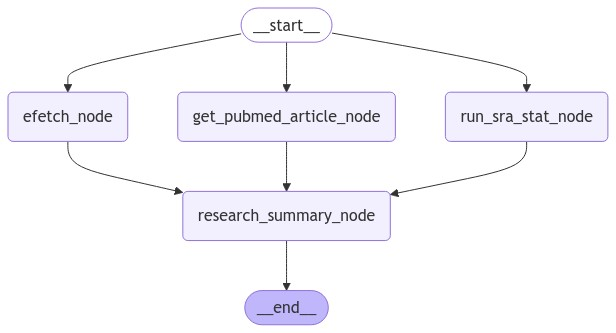

In [43]:
from IPython.display import Image
Image(subgraph.get_graph().draw_mermaid_png())

In [44]:
# # Call the graph and stream
# #input = {"entrez_id" : "35966237", "database" : "sra"}
# input = {"entrez_id" : "36029097", "database" : "sra"}
# final_step = None
# for step in subgraph.stream(input, config={"max_concurrency" : 3, "recursion_limit": 30}):
#     print(step)
#     final_step = step

In [45]:
# final_step

In [46]:
# Function to invoke the subgraph
def invoke_subgraph(state: SubState):
    #message = HumanMessage(content=f"Entrez ID: {state['entrez_id']}, Database: {state['database']}")
    response = subgraph.invoke({
        "entrez_id" : state["entrez_id"],
        "database" : state["database"]
    })
    return {
        "accessions": [response["accessions"]],
        "is_single_cell": [response["is_single_cell"]],
        "is_illumina": [response["is_illumina"]],
        "is_paired_end": [response["is_paired_end"]],
        "is_10x": [response["is_10x"]],
        "explanations": [response["explanation"]]
    }

#ret = invoke_subgraph({"entrez_id" : "36004814", "database" : "sra"})
#ret = invoke_subgraph({"entrez_id" : "35966233", "database" : "sra"})
#ret

In [47]:
# GEO record ID
#ret = invoke_subgraph({"entrez_id" : "200268899", "database" : "gds"})
#ret

## Graph

In [48]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    database: str
    # esearch IDs
    entrez_ids: Annotated[List[str], operator.add]
    # converted IDs
    converted_entrez_ids: Annotated[List[str], operator.add]
    # accessions
    accessions: Annotated[List[List[str]], operator.add]
    # is_single_cell
    is_single_cell: Annotated[List[YesNo], operator.add]
    # is_illumina
    is_illumina: Annotated[List[YesNo], operator.add]
    # is_paired_end
    is_paired_end: Annotated[List[YesNo], operator.add]
    # is_10x
    is_10x: Annotated[List[YesNo], operator.add]
    # explanations
    explanations: Annotated[List[str], operator.add]

In [60]:
def invoke_esearch(state: TopState):
    query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
    entrez_ids = esearch.invoke({"esearch_query" : query, "database" : state["database"]})
    return {"entrez_ids" : entrez_ids}

# create react agent
def invoke_sra2geo(state: TopState):
    """
    Invoke the geo2sra tool to get SRA accessions for a GEO dataset.
    """
    # invoke tool
    sra_ids = geo2sra.invoke({"entrez_ids" : state["entrez_ids"]})
    # update state
    return {"converted_entrez_ids" : sra_ids, "database" : "sra"}

# ID conversion router
def id_convert_router(state: TopState):
    """
    Route the Entrez IDs to the appropriate conversion tool.
    """
    if state["database"] == "gds":
        return ["id_convert_node"]
    else:
        return ["id_agg_node"]

def id_agg(state: TopState):
    """
    Aggregate IDs from various nodes
    """
    return {"database" : state["database"]}

# Parallel invoke of the subgraph
def continue_to_subgraphs(state: TopState):
    # check if there are any converted IDs
    if len(state["converted_entrez_ids"]) > 0:
        entrez_ids = state["converted_entrez_ids"]
    else:
        entrez_ids = state["entrez_ids"]
    # invoke the subgraph for each ID
    return [Send("invoke_subgraph", {"entrez_id": x, "database" : state["database"]}) for x in entrez_ids]

def final_state(state: TopState):
    # which entrez IDs to return?
    entrez_ids = []
    if len(state["converted_entrez_ids"]) > 0:
        entrez_ids = state["converted_entrez_ids"]
    else:
        entrez_ids = state["entrez_ids"]
    # return final state
    return {
        "database": state["database"],
        "entrez_ids": entrez_ids,
        "accessions": state["accessions"],
        "is_single_cell": state["is_single_cell"],
        "is_illumina": state["is_illumina"],
        "is_paired_end": state["is_paired_end"],
        "is_10x": state["is_10x"],
        "explanations": state["explanations"]
    }

# test of final_state
# state = {
#     "database" : "sra",
#     "entrez_ids" : ["test"],
#     "converted_entrez_ids" : [],
#     "accessions" : [],
#     "is_single_cell" : [],
#     "is_illumina" : [],
#     "is_paired_end" : [],
#     "is_10x" : [],
#     "explanations" : []
# }
# final_state(state)

In [62]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("esearch_node", invoke_esearch)
workflow.add_node("id_convert_node", invoke_sra2geo)
workflow.add_node("id_agg_node", id_agg)
workflow.add_node("invoke_subgraph", invoke_subgraph)
workflow.add_node("final_state_node", final_state)

# edges
workflow.add_edge(START, "esearch_node")
workflow.add_conditional_edges("esearch_node", id_convert_router, ["id_convert_node", "id_agg_node"])
workflow.add_edge("id_convert_node", "id_agg_node")
workflow.add_conditional_edges("id_agg_node", continue_to_subgraphs, ["invoke_subgraph"])
workflow.add_edge("invoke_subgraph", "final_state_node")
workflow.add_edge("final_state_node", END)

# compile the graph
graph = workflow.compile()

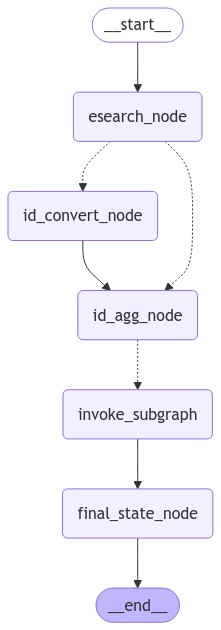

In [63]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [64]:
# Call the graph: SRA database
final_state = None
for step in graph.stream({"database": "sra"}, subgraphs=True, config={"max_concurrency" : 3, "recursion_limit": 40}):
    print(step)
    final_state = step

((), {'esearch_node': {'entrez_ids': ['36058903', '36058868']}})
((), {'id_agg_node': {'database': 'sra'}})
(('invoke_subgraph:c7c6da7d-0a5c-df0e-31c4-5653623a7f02',), {'efetch_node': {'messages': [HumanMessage(content='#-- efetch results --#\n<?xml version="1.0" encoding="UTF-8"  ?>\n<EXPERIMENT_PACKAGE_SET>\n<EXPERIMENT_PACKAGE><EXPERIMENT accession="ERX13269217" alias="E-MTAB-12303:CTCL5_Epi_45P_8N_GEX_S2_p" broker_name="ArrayExpress" center_name="European Bioinformatics Institute"><IDENTIFIERS><PRIMARY_ID>ERX13269217</PRIMARY_ID></IDENTIFIERS><TITLE>Single cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma (CTCL)</TITLE><STUDY_REF accession="ERP165377"><IDENTIFIERS><PRIMARY_ID>ERP165377</PRIMARY_ID><EXTERNAL_ID namespace="BioProject">PRJEB81542</EXTERNAL_ID></IDENTIFIERS></STUDY_REF><DESIGN><DESIGN_DESCRIPTION>Single cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma (CTCL)</DESIGN_DESCRIPTION><SAMPLE_DESCRIPTOR accession="ERS21345106

In [65]:
# # Call the graph: GEO database
# final_state = None
# for step in graph.stream({"database": "gds"}, subgraphs=True, config={"max_concurrency" : 2, "recursion_limit": 30}):
#     print(step)
#     final_state = step

In [66]:
# get final state
final_state[1]["final_state_node"]

{'database': 'sra',
 'entrez_ids': ['36058903', '36058868'],
 'accessions': [['ERX13269159', 'ERR13866465'],
  ['ERR13866633', 'ERX13269217', 'ERS21345106', 'ERA30901301', 'ERP165377']],
 'is_single_cell': ['Yes', 'Yes'],
 'is_illumina': ['Yes', 'Yes'],
 'is_paired_end': ['No', 'No'],
 'is_10x': ['Yes', 'Yes'],
 'explanations': ["The dataset is identified as single-cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma. The library source is specified as 'TRANSCRIPTOMIC SINGLE CELL' and the library strategy is 'RNA-Seq'. The platform is Illumina, specifically the NovaSeq 6000 model. Additionally, the library was constructed using the 10x Genomics protocol, which is mentioned explicitly in the library construction protocol.",
  'The dataset is characterized as single-cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma. It is sequenced using Illumina technology (NovaSeq 6000), and it specifically mentions the use of 10x Chromium for cell capture

In [67]:
# convert to a dataframe
results = pd.DataFrame(final_state[1]['final_state_node'])
results

,database,entrez_ids,accessions,is_single_cell,is_illumina,is_paired_end,is_10x,explanations
0,sra,36058903,"[ERX13269159, ERR13866465]",Yes,Yes,No,Yes,"The dataset is identified as single-cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma. The library source is specified as 'TRANSCRIPTOMIC SINGLE CELL' and the library strategy is 'RNA-Seq'. The platform is Illumina, specifically the NovaSeq 6000 model. Additionally, the library was constructed using the 10x Genomics protocol, which is mentioned explicitly in the library construction protocol."
1,sra,36058868,"[ERR13866633, ERX13269217, ERS21345106, ERA30901301, ERP165377]",Yes,Yes,No,Yes,"The dataset is characterized as single-cell RNA-seq of skin biopsies from patients with cutaneous T cell lymphoma. It is sequenced using Illumina technology (NovaSeq 6000), and it specifically mentions the use of 10x Chromium for cell capture. The library layout is tagged as SINGLE, which indicates it is not paired-end."
